![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [3]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [4]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1

import numpy as np
X_train[['M_Camry','M_Camry4dr','M_CamryBase','M_CamryL','M_CamryLE','M_CamrySE','M_CamryXLE']] = X_train[['M_Camry','M_Camry4dr','M_CamryBase','M_CamryL','M_CamryLE','M_CamrySE','M_CamryXLE']].astype(int)
X_test[['M_Camry','M_Camry4dr','M_CamryBase','M_CamryL','M_CamryLE','M_CamrySE','M_CamryXLE']] = X_test[['M_Camry','M_Camry4dr','M_CamryBase','M_CamryL','M_CamryLE','M_CamrySE','M_CamryXLE']].astype(int)

def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

def gini_impurity(X_col, y, split):

    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]

    n_l = y_l.shape[0]
    n_r = y_r.shape[0]

    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)

    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)

    return gini_impurity_

def best_split(X, y, num_pct=10):

    features = range(X.shape[1])

    best_split = [0, 0, 0]  # j, split, gain

    # Para todas las varibles
    for j in features:

        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]

        # Para cada partición
        for split in splits:
            gain = gini_impurity(X.iloc[:, j], y, split)

            if gain > best_split[2]:
                best_split = [j, split, gain]

    return best_split

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):

    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree

    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)

    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5)
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace

    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree

    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición

    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)

    return tree

arbol_man = tree_grow(X_train, y_train, level=0, min_gain=0.001, max_depth=4, num_pct=10)

def tree_predict(X, tree, proba=False):

    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']

    else:

        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted

y_predic_man = tree_predict(X_test, arbol_man)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

MSE_arbol_man = mean_squared_error(y_test, y_predic_man)
RMSE_arbol_man = math.sqrt(MSE_arbol_man)
MAE_arbol_man = mean_absolute_error(y_test, y_predic_man)
print("El error cuadratico medio (RMSE) del árbol estimado es: " + str(RMSE_arbol_man))
print("El error medio (MAE) del árbol estimado es: " + str(MAE_arbol_man))


El error cuadratico medio (RMSE) del árbol estimado es: 15113.767253661932
El error medio (MAE) del árbol estimado es: 14598.966224018475


### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [6]:
# Celda 2
from sklearn.tree import DecisionTreeRegressor

#Creación muestras Bootstrap
np.random.seed(123)
n_samples = X_train.shape[0]
n_B = 10
samples = [np.random.choice(a=n_samples, size=n_samples, replace=True) for _ in range(1, n_B +1 )]

#Construccion árboles para muestras
arboles_reg = DecisionTreeRegressor(max_depth=None, random_state=123)
y_pred_man_bag = pd.DataFrame(index=X_test.index, columns=[list(range(n_B))])

#Entrenamiento de árboles y generación de predicciones
for i, sample in enumerate(samples):
  X_train_bag = X_train.iloc[sample, 0:]
  y_train_bag = y_train.iloc[sample]
  arboles_reg.fit(X_train_bag, y_train_bag)
  y_pred_man_bag.iloc[:,i] = arboles_reg.predict(X_test)

#Rendimiento del modelo
MSE_bag_man = mean_squared_error(y_test, y_pred_man_bag.mean(axis=1))
RMSE_bag_man = math.sqrt(MSE_bag_man)
MAE_bag_man = mean_absolute_error(y_test, y_pred_man_bag.mean(axis=1))
print("El error cuadratico medio (RMSE) del modelo Bagging manual estimado es: " + str(RMSE_bag_man))
print("El error medio (MAE) del modelo Bagging manual estimado es: " + str(MAE_bag_man))

El error cuadratico medio (RMSE) del modelo Bagging manual estimado es: 1796.4355868399332
El error medio (MAE) del modelo Bagging manual estimado es: 1340.0160739030025


Al entrenar un modelo bagging con 10 árboles de regresión, no se encuentra un rendimiento predictivo confiable ya que se observan errores elevados al comparar las predicciones con los valores de prueba.

### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [7]:
# Celda 3
# Importación de paquetes
from sklearn.tree import DecisionTreeRegressor

# Separación de variables predictoras (X) y variable de interés (y) en set de entrenamiento y test
from sklearn.ensemble import BaggingRegressor

## arbol_regresion = DecisionTreeRegressor(max_features=int(np.log2(X.shape[1])))


bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10,
                          bootstrap=True, oob_score=True, random_state=1, max_features = int(np.log2(X.shape[1])))

# Entrenemiento del modelo con set de entrenamiento y predicción en el set de test
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

# Cálculo del error del modelo
rmse_bagging = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_bagging

2013.353269091173

Posteriormente, calculamos el error OOB como sigue:

In [8]:
bagreg.oob_score_

0.5058984556933224

En comparación con el modelo manual, el modelo estimado a partír de la librería Sklearn presenta un peor desempeño con un error cuadratico medio mayor que el modelo manual, indicando que no es una alternativa óptima para las predicciones asociadas a los datos disponibles.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [9]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# Definición de modelo Random Forest para un problema de clasificación
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [10]:
#Impresión de desempeño del modelo usando la función cross_val_score
mse_scores = cross_val_score(rf, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
rmse_scores = pd.DataFrame(np.sqrt(mse_scores), columns=["rmse"])

rmse_scores.describe()

,rmse
count,10.000000
mean,1770.679158
std,108.226421
min,1609.506971
25%,1696.998895
50%,1751.822862
75%,1831.533267
max,1958.096913


El modelo Random Forest estimado presenta un desempeño predictivo relativamente bajo, con errores elevados para un contexto de análisis predictivo.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

In [11]:
import matplotlib.pyplot as plt

#### 5.1. Calibración de max_depth

In [12]:
max_depth_range = [1, 2, 5, 10, 15, 20]

# Definición de lista para almacenar el RMSE promedio para cada valor de max_depth
rmse_scores_rf = []

for max_depth in max_depth_range:
    rf = RandomForestRegressor(max_depth = max_depth, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    mse_scores = cross_val_score(rf, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores
    rmse_values = np.sqrt(mse_scores)
    rmse_scores_rf.append(rmse_values.mean())

Text(0, 0.5, 'RMSE')

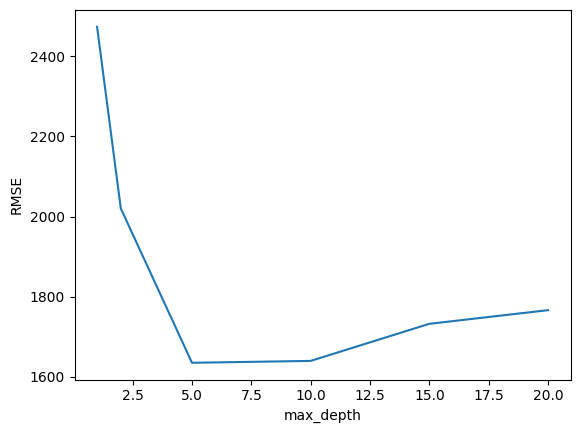

In [13]:
# Gráfica del desempeño del modelo vs el valor de max_depth
plt.plot(max_depth_range, rmse_scores_rf)
plt.xlabel('max_depth')
plt.ylabel('RMSE')

Tal y como observamos, el valor del RMSE disminuye a medida que max_depth aumenta, llegando al mínimo cuando max_depth es igual a 5 (punto de inflexión). A partir de este valor, el RMSE empieza a aumentar. En ese sentido, se elige un valor de 5 para el parámetro max_depth.

#### 5.2. Calibración de n_estimators

In [14]:
# Creación de lista de valores para iterar sobre diferentes valores de n_estimators
estimator_range = range(10, 400, 10)

# Definición de lista para almacenar el RMSE promedio para cada valor de n_estimators
rmse_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de n_estimators
for estimator in estimator_range:
    rf = RandomForestRegressor(n_estimators=estimator, max_depth = 5, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    mse_scores = cross_val_score(rf, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores
    rmse_values = np.sqrt(mse_scores)
    rmse_scores_rf.append(rmse_values.mean())

Text(0, 0.5, 'RMSE')

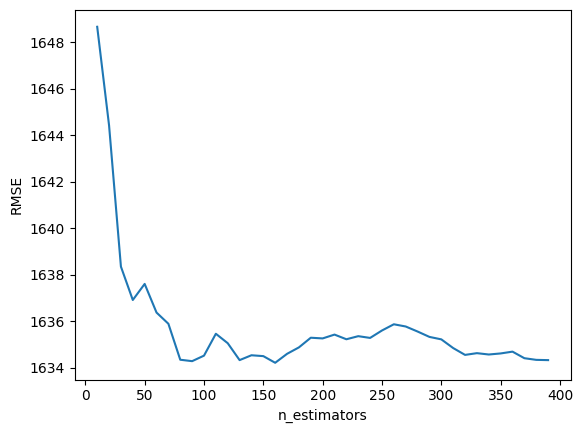

In [15]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators
plt.plot(estimator_range, rmse_scores_rf)
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

Como se puede observar, el valor del RMSE disminuye a medida que aumenta el valor de n_estimators, sin embargo, la métrica parece estabilizarse a partir de n_estimators = 200, por lo que se trabajará con este valor.

#### 5.3. Calibración de max_features

In [16]:
# Creación de lista de valores para iterar sobre diferentes valores de max_features
feature_range = range(1, len(X.columns)+1)

# Definición de lista para almacenar el RMSE promedio para cada valor de max_features
rmse_scores_rf = []

# Uso de un 5-fold cross-validation para cada valor de max_features
for feature in feature_range:
    rf = RandomForestRegressor(n_estimators=200, max_depth = 5, max_features=feature, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)
    mse_scores = cross_val_score(rf, X_test, y_test, cv=5, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores
    rmse_values = np.sqrt(mse_scores)
    rmse_scores_rf.append(rmse_values.mean())

Text(0, 0.5, 'RMSE')

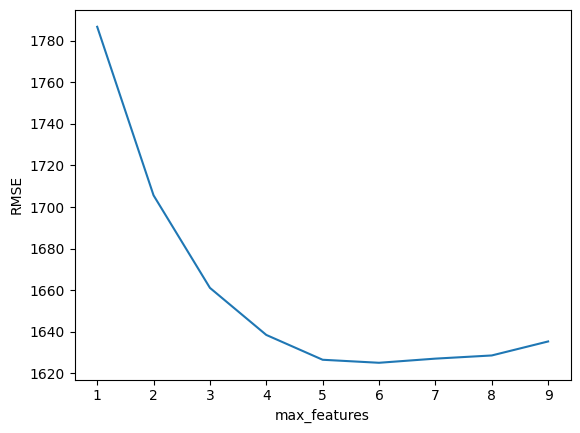

In [17]:
# Gráfica del desempeño del modelo vs el valor de max_features
plt.plot(feature_range, rmse_scores_rf)
plt.xlabel('max_features')
plt.ylabel('RMSE')

Para este caso, el menor valor para el RMSE se obtiene con un max_features de 6, por lo que seleccionamos este valor.

#### 5.4. Implementación de Random Forest Regressor con los mejores parámetros

In [18]:
rf_final = RandomForestRegressor(n_estimators=200, max_depth = 5, max_features=6, random_state=1, n_jobs=-1)
rf_final.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=6, n_estimators=200, n_jobs=-1,
                      random_state=1)

In [19]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature':X.columns, 'importance':rf_final.feature_importances_}).sort_values('importance')

,feature,importance
4,M_CamryBase,0.000054
5,M_CamryL,0.000201
2,M_Camry,0.002418
6,M_CamryLE,0.002975
7,M_CamrySE,0.003434
8,M_CamryXLE,0.011932
3,M_Camry4dr,0.024196
1,Mileage,0.311257
0,Year,0.643533


In [20]:
#Impresión de desempeño del modelo usando la función cross_val_score
mse_scores = cross_val_score(rf_final, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
rmse_scores_rf = pd.DataFrame(np.sqrt(mse_scores), columns=["rmse"])

rmse_scores_rf.describe()

,rmse
count,10.000000
mean,1620.963781
std,127.505586
min,1395.709711
25%,1539.330422
50%,1626.652284
75%,1695.672725
max,1828.434319


In [21]:
rmse_random_forest = rmse_scores_rf['rmse'].mean()
rmse_random_forest

1620.9637807328177

Al calibrar los parámetros del modelo Random Forest, se obtienen los siguientes resultados:

*   **max_depth** = 5

*   **max_features** = 6

*   **n_estimators** = 20

El valor de max_depth afecta el número de niveles permitido a cada árbol de decisión del modelo, valores bajos (menores a 5) pueden llevar a que el modelo no se ajuste completamente a los datos (undefitting), mientras que valores altos (mayores a 20) pueden implicar lo contrario y llevar a problemas de overfitting.

Max_features controla la complejidad del modelo y de cada árbol de decisión al poner un limite al número de variables predictoras que se pueden utilizar en cada estimación.

N_estimators determina el número de árboles de decisión estimados en el modelo, en este caso el número óptimo fue de 200, lo que se considera un número aceptable (número alto de árboles) ya que estó implicará mayor precisión en las predicciones, sin embargo, números demasiado elevados requerirán de recursos computacionales óptimos.

En cuanto al desempeño del modelo, se observa una mejoría respecto a modelos previos (errores más bajos), por lo que se puede afirmar que la calibración tiene una útilidad práctica evidente.

Además se encuentra que las variables más importantes dentro de la estimación del modelo son Year y Mileage, lo que concuerda con la teoría ya que estos son dos elementos fundamentales al momento de determinar el valor de venta de un automovil (su modelo o año de producción, y su kilometraje).

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [22]:
# Importación
!pip install xgboost
from xgboost import XGBRegressor
from sklearn import metrics

In [23]:
# Definición del modelo
XGB = XGBRegressor(random_state=1, n_jobs=-1)
XGB

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=1, ...)

In [25]:
# Entrenamiento (fit) y desempeño del modelo XGBRegressor
XGB.fit(X_train, y_train)

y_pred = XGB.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_pred, y_test.values))
rmse

1605.2355199928948

In [26]:
mse_scores = cross_val_score(XGB, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
rmse_scores_XGB = pd.DataFrame(np.sqrt(mse_scores), columns=["rmse"])

rmse_scores_XGB.describe()

,rmse
count,10.000000
mean,1680.813755
std,113.618631
min,1478.690524
25%,1633.012998
50%,1659.395278
75%,1772.520585
max,1844.186243


El modelo XGBoost de regresión implementado no presenta mejorías notables comparado con los modelos anteriores, de hecho, se observan errores mayores que los encontrados con los Random Forest iniciales.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### 7.1. Calibración de learning rate

In [27]:
learning_rate_range = [0.01, 0.03, 0.05, 0.1, 0.2, 0.3]

rmse_scores_XGB = []

for learning_rate in learning_rate_range:
    XGB = XGBRegressor(learning_rate = learning_rate, random_state=1, n_jobs=-1)
    XGB.fit(X_train, y_train)
    mse_scores = cross_val_score(XGB, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores
    rmse_values = np.sqrt(mse_scores)
    rmse_scores_XGB.append(rmse_values.mean())

Text(0, 0.5, 'RMSE')

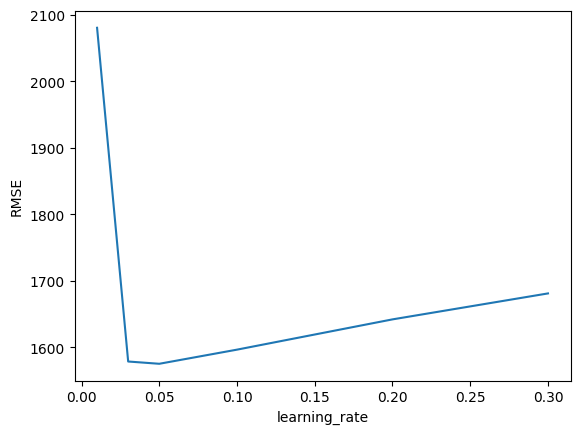

In [28]:
# Gráfica del desempeño del modelo vs el valor de learning_rate
plt.plot(learning_rate_range, rmse_scores_XGB)
plt.xlabel('learning_rate')
plt.ylabel('RMSE')

Observamos que el menor valor para el RMSE se obtiene con un learning_rate de 0.05, por lo que utilizamos este valor para este parámetro.

#### 7.2. Calibración de gamma

In [29]:
gamma_range = [0.1, 0.2, 0.5, 1, 2, 5, 8, 11, 14, 17]

rmse_scores_XGB = []

for gamma in gamma_range:
    XGB = XGBRegressor(learning_rate = 0.05, gamma = gamma, random_state=1, n_jobs=-1)
    XGB.fit(X_train, y_train)
    mse_scores = cross_val_score(XGB, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores
    rmse_values = np.sqrt(mse_scores)
    rmse_scores_XGB.append(rmse_values.mean())

Text(0, 0.5, 'RMSE')

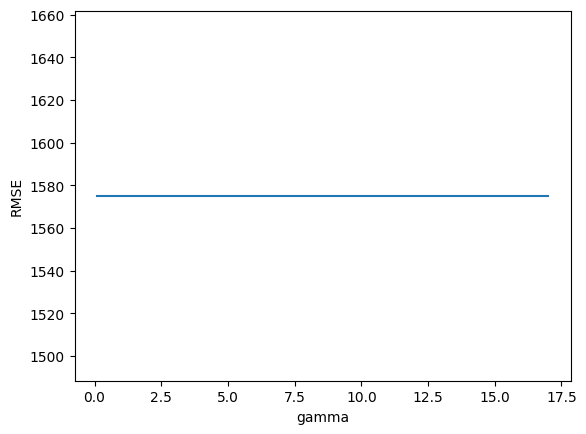

In [30]:
# Gráfica del desempeño del modelo vs el valor de gamma
plt.plot(gamma_range, rmse_scores_XGB)
plt.xlabel('gamma')
plt.ylabel('RMSE')

Para estas condiciones particulares, observamos que el valor de gamma no tiene aparente influencia sobre el RMSE, por lo que procedemos a utilizar el valor que por defecto maneja XGBoost, el cual es de 0.

#### 7.3. Calibración de colsample_bytree

In [31]:
colsample_bytree_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

rmse_scores_XGB = []

for colsample_bytree in colsample_bytree_range:
    XGB = XGBRegressor(learning_rate = 0.05, colsample_bytree = colsample_bytree, random_state=1, n_jobs=-1)
    XGB.fit(X_train, y_train)
    mse_scores = cross_val_score(XGB, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
    mse_scores = -mse_scores
    rmse_values = np.sqrt(mse_scores)
    rmse_scores_XGB.append(rmse_values.mean())

Text(0, 0.5, 'RMSE')

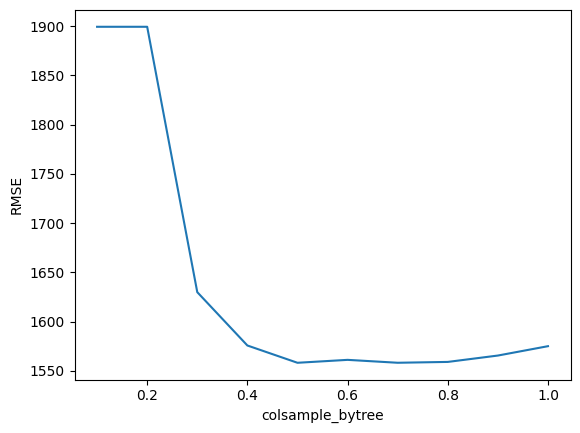

In [32]:
# Gráfica del desempeño del modelo vs el valor de colsample_bytree
plt.plot(colsample_bytree_range, rmse_scores_XGB)
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE')

Finalmente, el desempeño del modelo es el mejor cuando el parámetro colsample_bytree toma el valor de 0.6

#### 7.4. Implementación de XGBoost Regressor con los mejores parámetros

In [33]:
XGB_final = XGBRegressor(learning_rate = 0.05, colsample_bytree = 0.6, random_state=1, n_jobs=-1)
XGB_final.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=1, ...)

In [34]:
mse_scores = cross_val_score(XGB_final, X_test, y_test, cv=10, scoring='neg_mean_squared_error')
mse_scores = -mse_scores
rmse_scores_XGB = pd.DataFrame(np.sqrt(mse_scores), columns=["rmse"])

rmse_scores_XGB.describe()

,rmse
count,10.000000
mean,1561.167840
std,118.223768
min,1339.490099
25%,1525.528919
50%,1553.860024
75%,1634.045113
max,1759.526698


In [35]:
rmse_XGB = rmse_scores_XGB['rmse'].mean()
rmse_XGB

1561.1678398775173

Al calibrar los parámetros, se observa una mejoría notable en el desempeño del modelo XGBoost de regresión. Comparado con las estimaciones sin calibrar, hay una reducción considerable de los errores de predicción corroborando que la calibración es una práctica necesaria para sacar el máximo potencial del algoritmo implementado.

Durante el proceso de claibración se obtuvieron los siguientes resultados:

*   **learning_rate** =  0.05

*   **gamma** = 0

*   **colsample_bytree** = 0.6

Un learning rate bajo es lo aconsejable de acuerdo a la teoría, ya que este parametro ajusta la capacidad del modelo para ajustar su capacidad computacional a los datos (un valor bajo implica mayor tiempo para actualizar el modelo ya ajsutarlo a los datos, pero mayor precisión).

Colsample_bytree ajusta el porcentaje de variables predictoras utilizadas en cada árbol (se utilizó el 50% en el modelo estimado), utilizar valores medios a bajos implica modelos menos complejos y previene el fenómeno de overfitting.

El parametro gamma controla la complejidad del modelo y previene problemas como overfitting. Valores bajos implican que no exista regularización (asignación de penalizaciones a la función de pérdida), mientras que valores altos aumentan el grado de regularización utilizado (valor maximo = 20).

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

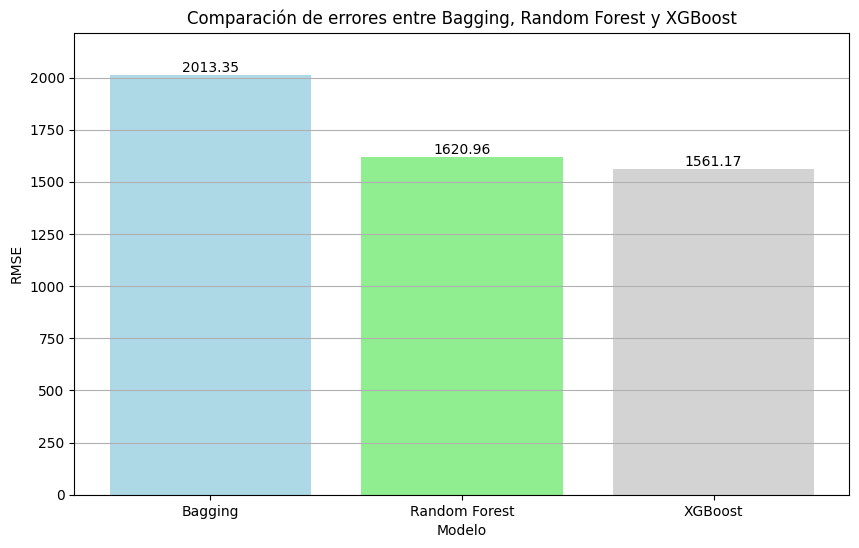

In [36]:
model_names = ['Bagging', 'Random Forest', 'XGBoost']
errors = [rmse_bagging, rmse_random_forest, rmse_XGB]

plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, errors, color=['lightblue', 'lightgreen', 'lightgray'])

for bar, error in zip(bars, errors):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{error:.2f}',
             ha='center', va='bottom', color='black', fontsize=10)

plt.xlabel('Modelo')
plt.ylabel('RMSE')
plt.title('Comparación de errores entre Bagging, Random Forest y XGBoost')
plt.ylim(0, max(errors) * 1.1)
plt.grid(axis='y')
plt.show()

Al comparar los modelos construidos con parámetros óptimos, evidenciamos en ambos casos una disminución significativa del error en comparación con modelos de árboles de decisión. Sin embargo al compararlos entre sí podemos concluir que a partir de las observaciones analizadas, el mejor modelo para predecir el precio de un automóvil, es el XGBoost con parámetros óptimos.

A continuación, presentamos las ventajas de emplear un modelo XGBoost con parámetros óptimos en comparación con un modelo de Random Forest:

**Rendimiento del Modelo:**

**XGBoost:** es conocido por su rendimiento excepcional en problemas de regresión y clasificación. Ha ganado numerosos concursos de Kaggle y se considera uno de los mejores algoritmos.

**Random Forest:** también es sólido, pero XGBoost tiende a superarlo en términos de precisión y velocidad.


---


**Regularización Incorporada:**

**XGBoost:** incluye regularización incorporada, lo que ayuda a prevenir el sobreajuste. Puedes ajustar los hiperparámetros para controlar la regularización.

**Random Forest:** no tiene regularización incorporada, por lo que puede ser más propenso al sobreajuste.


---


**Manejo de Valores Faltantes:**

**XGBoost:** puede manejar valores faltantes automáticamente durante el entrenamiento.

**Random Forest:** no maneja valores faltantes de manera tan eficiente.


---


**Tratamiento de Valores Atípicos:**

**XGBoost:** proporciona varias formas de tratar valores atípicos.

**Random Forest:** no ofrece opciones específicas para tratar valores atípicos.


---


**Velocidad de Ejecución:**

**XGBoost:** es más rápido que Random Forest debido a su optimización interna y paralelización.

**Random Forest:** puede ser más lento en comparación.

En resumen, XGBoost es un modelo con alto rendimiento, regularización incorporada y manejo eficiente de valores faltantes. Sin embargo, Random Forest sigue siendo una opción sólida en muchos casos.